In [1]:
import pyodbc
import pandas as pd
import numpy as np
from pandasql import sqldf
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from ut_connection_lib import Connection, Query
from ut_pdm_tools_lib import CommonFunctions
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from ut_data_preprocessing_lib import \
    VHMSReplaceSensorErrorValue, DeriveInteractionFeatures, DfMapMinMaxScaler, DfStandardScaler, FeaturesSelector, \
    RemoveByThreshold, InverseTransfromStandardScaller
    
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.options.mode.chained_assignment = None  # default='warn'

## Get Data From Database

In [ ]:
prod_connection = Connection(dbname="PROD")
dev_connection = Connection(dbname="DEVELOPMENT")

In [ ]:
unit_population_history_query = Query(source_file="sql_query/sql_query_unit_population_history.txt")
unit_population_latest_query = Query(source_file="sql_query/sql_query_unit_population_latest.txt")
vhms_trend_hd785_query = Query(source_file="sql_query/sql_query_vhms_trend_hd785.txt")
vhms_payload_hd785_daily_query = Query(source_file="sql_query/sql_query_vhms_payload_hd785_daily_summary.txt")
vhms_fault_hd785_query = Query(source_file="sql_query/sql_query_vhms_fault_hd785.txt")
vhms_chastrend_hd785_query = Query(source_file="sql_query/sql_query_chastrend_hd785.txt")
pap_oil_query = Query(source_file="sql_query/sql_query_pap_oil.txt")

In [ ]:
unit_population_history = unit_population_history_query.execute(prod_connection)
unit_population_latest = unit_population_latest_query.execute(prod_connection)
vhms_trend_hd785 = vhms_trend_hd785_query.execute(prod_connection)
vhms_pld_hd785_daily = vhms_payload_hd785_daily_query.execute(prod_connection)
vhms_chastrend_hd785 = vhms_chastrend_hd785_query.execute(prod_connection)
pap_oil = pap_oil_query.execute(prod_connection)

## Get Data From Local File

unit_population_history = pd.read_excel('local_data/unit_population_history.xlsx')
unit_population_latest = pd.read_excel('local_data/unit_population_latest.xlsx')
hist_comp_repl = pd.read_excel('local_data/historical_component_replacement.xlsx')
vhms_trend_hd785 = pd.read_excel('local_data/vhms_trend_hd785.xlsx')
vhms_fault_hd785 = pd.read_excel('local_data/vhms_fault_hd785.xlsx')
vhms_chastrend_hd785 = pd.read_excel('local_data/vhms_chastrend_hd785.xlsx')
vhms_pld_hd785_daily = pd.read_excel('local_data/vhms_pld_hd785_daily.xlsx')
pap_oil = pd.read_excel('local_data/pap_oil.xlsx')

# VHMS Data Processing As Primary Data

In [3]:
# Select VHMS records that meet criteria

vhms_completeness_report = pd.read_excel("vhms_completeness_report.xlsx")
srl_num_passed = vhms_completeness_report[
    (vhms_completeness_report['COMPLETENESS']<2) & # ensure no duplication
    (vhms_completeness_report['COUNT']>=500) & # ensure data size
    (vhms_completeness_report['COMPLETENESS']>=0.75) # ensure data completeness
]['MCHN_SRL_NUM'].drop_duplicates().tolist()

# Select VHMS that match criteria
vhms_trend_hd785_selected = vhms_trend_hd785[
    (vhms_trend_hd785["UNIT_SRL_NUM"].isin(srl_num_passed)) &
    (vhms_trend_hd785["COOL_TEMP_MX"]>vhms_trend_hd785["AMBIENT_TEMPMAX"]) &
    (vhms_trend_hd785["TRAVELSPEED_MX"]>0) &
    (vhms_trend_hd785["ENG_SPEED_MX"]>0) 
].reset_index(drop=True)
vhms_trend_hd785_selected['UNIT_SRL_NUM'] = vhms_trend_hd785_selected['UNIT_SRL_NUM'].astype(str)

print("Number of units: {}".format(len(srl_num_passed)))
print("Number of records: {}".format(len(vhms_trend_hd785_selected)))

Number of units: 481
Number of records: 534760


In [283]:
# Initialize preprocessing classes
derivative_expressions = CommonFunctions.read_from_file("parameters/engine_derivative_params.txt")
vhms_params = CommonFunctions.read_from_file("parameters/engine_vhms_params.txt")
vhms_param_name = np.array([s.split(", ")[0] for s in vhms_params])
vhms_param_source = np.array([s.split(", ")[1] for s in vhms_params])
vhms_param_used = np.array([s.split(", ")[2] for s in vhms_params])
primary_features = vhms_param_name[np.where(vhms_param_source=='PRIMARY')]
final_features = vhms_param_name[np.where(vhms_param_used=='TRUE')]
z_score_anomaly_thres = [(-3,3 )]*len(final_features)

## Preprocess for VHMS Early As Healthy Sample

Health VHMS sample comes from 2 sources. Early SMR between 500 to 1000 hours and early SMR of later engine replacement

In [284]:
vhms_hd785_early = vhms_trend_hd785_selected[(vhms_trend_hd785_selected['SMR']<1500) & 
                                             (vhms_trend_hd785_selected['SMR']>500)]

standard_scaler = DfStandardScaler(final_features)
vhms_early_cleaning_pipe = Pipeline([
    ('sensor-error-handling', VHMSReplaceSensorErrorValue(primary_features)),
    ('features-derivator', DeriveInteractionFeatures(derivative_expressions)), 
    ('standard-scaler', standard_scaler),
    ('anomaly-removal', RemoveByThreshold(final_features, z_score_anomaly_thres)),
    ('inverse-standard-scaller', InverseTransfromStandardScaller(standard_scaler))
])
vhms_hd785_early_transformed = vhms_early_cleaning_pipe.fit_transform(vhms_hd785_early.copy())
vhms_hd785_early_transformed['TIMESTAMP'] = vhms_hd785_early_transformed['TIMESTAMP'].map(lambda x: str(x)[:19])
vhms_hd785_early_transformed['failure'] = 0

2019-04-24 13:19:20: Fitting sensor error scaler with data
	2019-04-24 13:19:20: Separate sensor value from mean calculation
	2019-04-24 13:19:20: Computing average value of each equipment
	2019-04-24 13:19:21: Computing average value of all equipment
	2019-04-24 13:19:21: Finish fitting scaler
2019-04-24 13:19:21: Transforming data
	2019-04-24 13:19:21: Replacing error value with average for each serial number
2019-04-24 13:19:21: Deriving expression 
	X['MED_EXH_TEMP'] = X[['LF_EXH_TEMP_MX', 'LR_EXH_TEMP_MX', 'RF_EXH_TEMP_MX', 'RR_EXH_TEMP_MX']].median(axis=1)
2019-04-24 13:19:21: Deriving expression 
	X['COOL_TEMP_MID'] = (X['COOL_TEMP_MX'] + X['COOL_TEMP_MN'])/2
2019-04-24 13:19:21: Deriving expression 
	X['COOL_TEMP_RANGE'] = (X['COOL_TEMP_MX'] - X['COOL_TEMP_MN'])
2019-04-24 13:19:21: Deriving expression 
	X['FUEL_PER_ENGINE_CYCLE'] = X['FUEL_RATE']*1E6/(60*X['ENG_SPEED_AV'])
2019-04-24 13:19:21: Deriving expression 
	X['COOL_TEMP_GRADIENT'] = X['ENG_OIL_TMP_MX']/X['COOL_TEMP_MX'

C:\Users\80117059\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\My Work - United Tractors\Data Scientist Team\RUL Redevelopment\ut_data_preprocessing_lib.py:71: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  X.loc[:,self.features] = self.standardscaler.transform(X[self.features])


### Some equipments are discarded due to abnormality in early lifetime 

In [285]:
unit_discarded = vhms_hd785_early[
    ~vhms_hd785_early['UNIT_SRL_NUM'].isin(vhms_hd785_early_transformed['UNIT_SRL_NUM'].tolist())
]['UNIT_SRL_NUM'].drop_duplicates().tolist()

discarded_units = unit_population_latest[
    unit_population_latest['SRL_NUM'].isin(unit_discarded)].sort_values('SRL_NUM').reset_index(drop=True)
discarded_units

SRL_NUM MODL_NUM    ROOM PLNT             SORT_FLD          CUSTOMER_NAME  \
0   30183  HD785-7  HD1143  BKJ                  NaN       SIMS JAYA KALTIM   
1    7436  HD785-7  DT3293  BNT                  NaN  PAMAPERSADA NUSANTARA   
2    7914  HD785-7     NaN  ADR                ADARO  PAMAPERSADA NUSANTARA   
3    7994  HD785-7  DT3568  BDI  MUTASI DARI BONTANG  PAMAPERSADA NUSANTARA   

  CONTRACT LAST_UPDATED_DATE  
0      FMC        2014-06-13  
1  NON-FMC        2011-12-20  
2  NON-FMC        2014-05-12  
3  NON-FMC        2019-02-25

## Discover Degrading VHMS as Failure Example

In [286]:
# VHMS failure from component replacement (late SMR)

sch_replacement = hist_comp_repl[(hist_comp_repl['MODL_UNIT']=='HD785-7') &  
                                 (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
                                 (hist_comp_repl['LIFETIME_HOUR']>=20000) &
                                 (hist_comp_repl['STATUS']=='SCH')][['SRL_NUM', 'STATUS', 'END_HM', 'LIFETIME_HOUR']]
sch_replacement['RUN_TO_FAILURE'] = sch_replacement['LIFETIME_HOUR'].apply(lambda x: 0.02*x if x<=25000 else 0.02*25000)

usc_replacement = hist_comp_repl[(hist_comp_repl['MODL_UNIT']=='HD785-7') &  
                                 (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
                                 (hist_comp_repl['STATUS']=='USC')][['SRL_NUM', 'STATUS', 'END_HM', 'LIFETIME_HOUR']]
usc_replacement['RUN_TO_FAILURE'] = 250

engine_replacement = pd.concat([sch_replacement, usc_replacement])
engine_replacement.columns = ['UNIT_SRL_NUM', 'STATUS', 'END_HM', 'LIFETIME', 'RUN_TO_FAILURE']

vhms_from_replacement = pd.merge(engine_replacement, vhms_trend_hd785_selected, how='inner', on='UNIT_SRL_NUM')
vhms_from_replacement = \
    vhms_from_replacement[
        (vhms_from_replacement['SMR'] > vhms_from_replacement['END_HM']-vhms_from_replacement['RUN_TO_FAILURE']) & 
        (vhms_from_replacement['SMR'] <= vhms_from_replacement['END_HM'])][vhms_trend_hd785.columns]

In [287]:
def label_vhms_from_fault(vhms_trend, vhms_fault, fault_code, minimum_duration):
    vhms_fault_specific = vhms_fault[(vhms_fault['CODE']==fault_code) & 
                                   (vhms_fault['TOTAL_DURATION_MINUTES'] >= minimum_duration)].copy()
    vhms_fault_specific['NUM_DAYS'] = \
        (vhms_fault_specific['TO_DATE'].astype(datetime) - vhms_fault_specific['FROM_DATE'].astype(datetime))/np.timedelta64(1, 'D')
    vhms_fault_specific.columns = ['UNIT_SRL_NUM'] + vhms_fault_specific.columns.tolist()[1:]
    
    pysql = lambda q: sqldf(q, locals())
    
    query = """
        SELECT 
            trend.*
        FROM vhms_fault_specific fault
        INNER JOIN vhms_trend trend
            ON fault.UNIT_SRL_NUM = trend.UNIT_SRL_NUM AND
               trend.TIMESTAMP >= date(fault.FROM_DATE,'-1 day') AND --fault.FROM_DATE - INTERVAL'2 DAYS'
               trend.TIMESTAMP < fault.TO_DATE
        WHERE fault.TOTAL_DURATION_MINUTES/fault.NUM_DAYS >= {0}
        ORDER BY UNIT_SRL_NUM, TIMESTAMP
    """.format(minimum_duration)
    vhms_from_fault = sqldf(query, locals())
    return vhms_from_fault

In [288]:
def reduce_by_key(data, group_key, sort_key, ascending=False):
    data_dedup = data.sort_values(group_key + sort_key, ascending=ascending).drop_duplicates(group_key, keep='first').copy()
    for key in group_key:
        data_dedup = data_dedup[data_dedup[key]==data_dedup[key]]
    return data_dedup

In [289]:
# VHMS failure from fault code occurence

# Lowering Of Engine Oil Pressure
vhms_from_fault_babazg = label_vhms_from_fault(vhms_trend_hd785_selected, vhms_fault_hd785, "B@BAZG", 30)
# Lowering of engine oil level
vhms_from_fault_babazk =label_vhms_from_fault(vhms_trend_hd785_selected, vhms_fault_hd785, "B@BAZK", 30)
# Engine Overheat
vhms_from_fault_babcns =label_vhms_from_fault(vhms_trend_hd785_selected, vhms_fault_hd785, "B@BCNS", 30)
# Blowby Pressure High > 10 KPa
vhms_from_fault_fabbzl =label_vhms_from_fault(vhms_trend_hd785_selected, vhms_fault_hd785, "F@BBZL", 60)
vhms_from_fault_fabbzl = vhms_from_fault_fabbzl[vhms_from_fault_fabbzl['BLOWBY_PRESS_MX']>30]

# Union all
vhms_from_fault = pd.concat([vhms_from_fault_babazg, vhms_from_fault_babazk, 
                             vhms_from_fault_babcns, vhms_from_fault_fabbzl]).drop_duplicates()

In [290]:
# VHMS failure from rule abnormality

vhms_from_rule_abnormality = vhms_trend_hd785_selected[
# high blowby press
    (vhms_trend_hd785_selected['BLOWBY_PRESS_MX']>=30) |
# overheat
    ((vhms_trend_hd785_selected['COOL_TEMP_MX']>=101) & (vhms_trend_hd785_selected['ENG_OIL_TMP_MX']>=121)) |
# low e_oil press
    ((vhms_trend_hd785_selected['E_OIL_P_HI_MN']<0.205) & (vhms_trend_hd785_selected['E_OIL_P_LO_MN']<0.049))
]

In [291]:
# Union all failure records
vhms_hd785_failure = pd.concat([vhms_from_fault, vhms_from_replacement, vhms_from_rule_abnormality])
vhms_hd785_failure = vhms_hd785_failure[vhms_hd785_failure["SMR"]>=6000]
vhms_hd785_failure['TIMESTAMP'] = vhms_hd785_failure['TIMESTAMP'].map(lambda x: str(x)[:19])
vhms_hd785_failure = vhms_hd785_failure.drop_duplicates()

vhms_failure_cleaning_pipe = Pipeline([
    ('sensor-error-handling', VHMSReplaceSensorErrorValue(primary_features)),
    ('features-derivator', DeriveInteractionFeatures(derivative_expressions)), 
])

vhms_hd785_failure_transformed = vhms_failure_cleaning_pipe.fit_transform(vhms_hd785_failure.copy())
vhms_hd785_failure_transformed['failure'] = 1

2019-04-24 13:20:54: Fitting sensor error scaler with data
	2019-04-24 13:20:54: Separate sensor value from mean calculation
	2019-04-24 13:20:54: Computing average value of each equipment
	2019-04-24 13:20:54: Computing average value of all equipment
	2019-04-24 13:20:54: Finish fitting scaler
2019-04-24 13:20:54: Transforming data
	2019-04-24 13:20:54: Replacing error value with average for each serial number
2019-04-24 13:20:54: Deriving expression 
	X['MED_EXH_TEMP'] = X[['LF_EXH_TEMP_MX', 'LR_EXH_TEMP_MX', 'RF_EXH_TEMP_MX', 'RR_EXH_TEMP_MX']].median(axis=1)
2019-04-24 13:20:54: Deriving expression 
	X['COOL_TEMP_MID'] = (X['COOL_TEMP_MX'] + X['COOL_TEMP_MN'])/2
2019-04-24 13:20:54: Deriving expression 
	X['COOL_TEMP_RANGE'] = (X['COOL_TEMP_MX'] - X['COOL_TEMP_MN'])
2019-04-24 13:20:54: Deriving expression 
	X['FUEL_PER_ENGINE_CYCLE'] = X['FUEL_RATE']*1E6/(60*X['ENG_SPEED_AV'])
2019-04-24 13:20:54: Deriving expression 
	X['COOL_TEMP_GRADIENT'] = X['ENG_OIL_TMP_MX']/X['COOL_TEMP_MX'

## Combine VHMS Failure and Early

In [292]:
vhms_dataset = reduce_by_key(
    pd.concat([vhms_hd785_early_transformed, vhms_hd785_failure_transformed]),
    group_key = ['UNIT_SRL_NUM', 'TIMESTAMP'],
    sort_key = ['failure'])
vhms_dataset[primary_features] = vhms_dataset[primary_features].astype(float)
vhms_dataset[final_features] = vhms_dataset[final_features].astype(float)
vhms_dataset['UNIT_SRL_NUM'] = vhms_dataset['UNIT_SRL_NUM'].astype(str)
vhms_dataset['TIMESTAMP'] = vhms_dataset['TIMESTAMP'].astype(str)
vhms_dataset = vhms_dataset[~vhms_dataset.isnull().any(axis=1)]

vhms_dataset.groupby('failure')['TIMESTAMP'].count()

failure
0    13781
1      867
Name: TIMESTAMP, dtype: int64

# Add Contract and Plant Details

In [293]:
unit_population_latest_hd785 = unit_population_latest[unit_population_latest['MODL_NUM']=='HD785-7'][['SRL_NUM', 'CONTRACT']]
unit_population_latest_hd785.columns = ['UNIT_SRL_NUM', 'CONTRACT']

vhms_x_info_dataset = pd.merge(
    vhms_dataset, unit_population_latest_hd785,
    how='inner', on='UNIT_SRL_NUM'
)

In [294]:
vhms_x_info_dataset.groupby(['CONTRACT', 'failure'])['UNIT_SRL_NUM'].count()

CONTRACT  failure
FMC       0           2025
          1            364
NON-FMC   0          11756
          1            503
Name: UNIT_SRL_NUM, dtype: int64

# Add PAP To Dataset

In [295]:
def join_vhms_with_pap(vhms, pap):
    pysql = lambda q: sqldf(q, locals())
    
    query = """
        SELECT 
            vhms.*, pap.LAB_NUM, pap.SAMPL_DT
        FROM vhms
        LEFT JOIN pap
            ON pap.SRL_NUM = vhms.UNIT_SRL_NUM AND
               vhms.TIMESTAMP >= pap.SAMPL_DT AND
               vhms.TIMESTAMP < date(pap.SAMPL_DT,'+30 day')
        ORDER BY UNIT_SRL_NUM, TIMESTAMP, SAMPL_DT DESC
    """
    
    return sqldf(query, locals())

In [296]:
pap_engine_hd785 = pap_oil[(pap_oil['MODL_NUM']=='HD785-7') & (pap_oil['COMPONENT']=='ENGINE')]
pap_engine_hd785['SRL_NUM'] = pap_engine_hd785['SRL_NUM'].astype(str)
pap_engine_hd785['SAMPL_DT'] = pap_engine_hd785['SAMPL_DT'].astype(str)
pap_engine_hd785_index = pap_engine_hd785[['LAB_NUM', 'SRL_NUM', 'MODL_NUM', 'HRS_KM_TOT', 'SAMPL_DT']]

In [297]:
vhms_x_pap_dataset = reduce_by_key(
    join_vhms_with_pap(vhms_x_info_dataset, pap_engine_hd785_index),
    group_key = ['UNIT_SRL_NUM', 'TIMESTAMP'],
    sort_key = ['SAMPL_DT'])
vhms_x_pap_dataset['has_pap'] = vhms_x_pap_dataset['LAB_NUM'].map(lambda x: 1 if x is not None and x==x else 0)

In [298]:
vhms_x_pap_dataset.groupby(['has_pap','failure'])['UNIT_SRL_NUM'].count()

has_pap  failure
0        0          11597
         1            496
1        0           2184
         1            371
Name: UNIT_SRL_NUM, dtype: int64

# Build Model With VHMS Only (Without PAP)

We only get few records that have PAP match. So we will try to build two models, without adn with PAP and compare both results. This section is for the first approach

### Under-sample healthy records to balance the label

In [299]:
# randomly sample 18% of fmc healthy data
fmc_healthy = vhms_x_info_dataset[(vhms_x_info_dataset['failure']==0) & 
                                  (vhms_x_info_dataset['CONTRACT']=='FMC')].sample(frac=0.18)

# and randomly sample 4.3% of non-fmc healthy data
nonfmc_healthy = vhms_x_info_dataset[(vhms_x_info_dataset['failure']==0) & 
                                     (vhms_x_info_dataset['CONTRACT']=='NON-FMC')].sample(frac=0.043)

# combine fmc and non-fmc healthy data with failure data
vhms_dataset_resample = pd.concat([fmc_healthy, 
                                   nonfmc_healthy, 
                                   vhms_x_info_dataset[vhms_x_info_dataset['failure']==1]
                                  ])
vhms_dataset_resample.groupby(['CONTRACT', 'failure'])['UNIT_SRL_NUM'].count()

CONTRACT  failure
FMC       0          364
          1          364
NON-FMC   0          506
          1          503
Name: UNIT_SRL_NUM, dtype: int64

### Train A Random Forest Classifiers

In [300]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [301]:
health_score_model = RFC(n_estimators=100, min_samples_split=10)
X = vhms_dataset_resample[final_features]
y = vhms_dataset_resample['failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

health_score_model.fit(X_train, y_train)
y_pred = health_score_model.predict(X_test)
health_score = health_score_model.predict_proba(X_test)
np.sum(y_test==y_pred)/len(y_test)

health_score_result = pd.DataFrame({
    "failure": y_test, 
    "health_score": health_score[:,0],
    "prediction": y_pred
})

### Accuracy on Testing Data

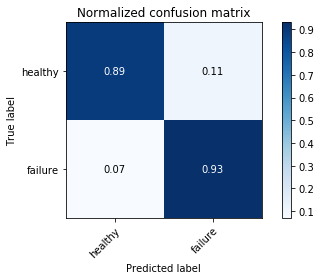

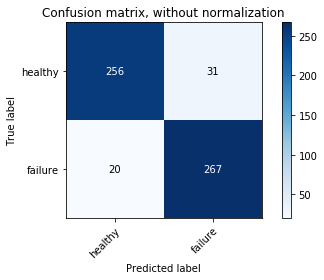

count       min      mean    median       max       std
failure                                                         
0          287  0.156308  0.793195  0.864654  0.998889  0.195843
1          287  0.000000  0.173364  0.119289  0.840585  0.170930

In [302]:
plot_confusion_matrix(y_test, y_pred, classes=['healthy', 'failure'], normalize=True)
plot_confusion_matrix(y_test, y_pred, classes=['healthy', 'failure'], normalize=False)
plt.show()
health_score_result.groupby('failure')['health_score'].agg(['count','min', 'mean', 'median', 'max', 'std'])

### Accuracy on Discarded Data (All Healthy)

In [303]:
discarded = vhms_dataset.loc[[i for i in vhms_dataset.index if i not in vhms_dataset_resample.index]]
X_discarded = discarded[final_features]
y_discarded = discarded['failure']
y_pred = health_score_model.predict(X_discarded)
health_score = health_score_model.predict_proba(X_discarded)
print("Accuracy: ", np.sum(y_discarded==y_pred)/len(y_discarded))
print("Average HS: ", np.mean(health_score[:,0]))
print("Median HS: ", np.median(health_score[:,0]))
print("Standard Deviation HS: ", np.std(health_score[:,0]))

Accuracy:  0.8974832444262071
Average HS:  0.7505108577644295
Median HS:  0.8415766777082565
Standard Deviation HS:  0.2429601565610073


### Degradation Curve Towards End of Lifetime

In [304]:
vhms_scoring_cleaning_pipe = Pipeline([
    ('sensor-error-handling', VHMSReplaceSensorErrorValue(primary_features)),
    ('features-derivator', DeriveInteractionFeatures(derivative_expressions)), 
])
vhms_scoring_cleaning_pipe.fit(vhms_trend_hd785_selected.copy())

2019-04-24 13:20:57: Fitting sensor error scaler with data
	2019-04-24 13:20:57: Separate sensor value from mean calculation
	2019-04-24 13:20:58: Computing average value of each equipment
	2019-04-24 13:21:16: Computing average value of all equipment
	2019-04-24 13:21:16: Finish fitting scaler
2019-04-24 13:21:16: Transforming data
	2019-04-24 13:21:16: Replacing error value with average for each serial number


Pipeline(memory=None,
     steps=[('sensor-error-handling', VHMSReplaceSensorErrorValue(features=array(['ENG_SPEED_MX', 'ENG_SPEED_AV', 'BLOWBY_PRESS_MX',
       'LF_EXH_TEMP_MX', 'LR_EXH_TEMP_MX', 'RF_EXH_TEMP_MX',
       'RR_EXH_TEMP_MX', 'BOOST_PRESS_MX', 'E_OIL_P_MX', 'E_OIL_P_LO_MN',
       'E_OIL_P_HI_MN', 'ENG_OIL_TMP_...'RPM_TO_SPEED_RATIO'] = np.log(X['ENG_SPEED_MX'].tolist())/np.log(X['TRAVELSPEED_MX'].tolist())"]))])

2019-04-25 08:03:45: Transforming data
	2019-04-25 08:03:45: Replacing error value with average for each serial number
2019-04-25 08:03:45: Deriving expression 
	X['MED_EXH_TEMP'] = X[['LF_EXH_TEMP_MX', 'LR_EXH_TEMP_MX', 'RF_EXH_TEMP_MX', 'RR_EXH_TEMP_MX']].median(axis=1)
2019-04-25 08:03:45: Deriving expression 
	X['COOL_TEMP_MID'] = (X['COOL_TEMP_MX'] + X['COOL_TEMP_MN'])/2
2019-04-25 08:03:45: Deriving expression 
	X['COOL_TEMP_RANGE'] = (X['COOL_TEMP_MX'] - X['COOL_TEMP_MN'])
2019-04-25 08:03:45: Deriving expression 
	X['FUEL_PER_ENGINE_CYCLE'] = X['FUEL_RATE']*1E6/(60*X['ENG_SPEED_AV'])
2019-04-25 08:03:45: Deriving expression 
	X['COOL_TEMP_GRADIENT'] = X['ENG_OIL_TMP_MX']/X['COOL_TEMP_MX']
2019-04-25 08:03:45: Deriving expression 
	X['ENG_SPEED_RANGE'] = X['ENG_SPEED_MX'] - X['ENG_SPEED_AV']
2019-04-25 08:03:45: Deriving expression 
	X['RPM_TO_SPEED_RATIO'] = np.log(X['ENG_SPEED_MX'].tolist())/np.log(X['TRAVELSPEED_MX'].tolist())


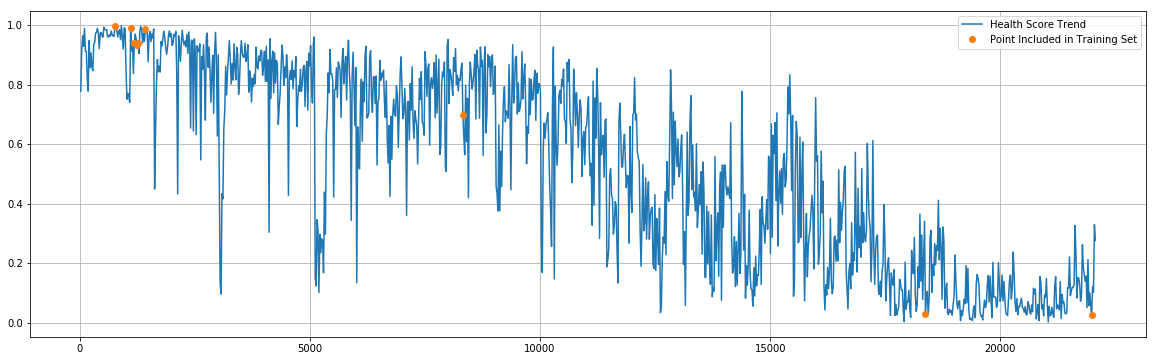

index                               4315
SRL_NUM                            30025
MODL_NUM                         HD785-7
ROOM                              HD1134
PLNT                                 BKJ
SORT_FLD                             NaN
CUSTOMER_NAME           SIMS JAYA KALTIM
CONTRACT                             FMC
LAST_UPDATED_DATE    2014-06-13 00:00:00
Name: 0, dtype: object


In [413]:
srl_num = '30025'
training_set = vhms_dataset_resample.loc[[i for i in vhms_dataset_resample.index if i in X_train.index]]
equipment_sample = vhms_scoring_cleaning_pipe.transform(
    vhms_trend_hd785_selected[vhms_trend_hd785_selected['UNIT_SRL_NUM']==srl_num].copy()).sort_values('SMR')
X = equipment_sample[final_features]
equipment_sample['health_score'] = health_score_model.predict_proba(X)[:,0]
equipment_sample['training_set'] = equipment_sample['SMR'].map(
    lambda x: x in training_set[training_set['UNIT_SRL_NUM']==srl_num]['SMR'].tolist())

plt.figure(figsize=(20,6))
plt.plot(equipment_sample['SMR'], equipment_sample['health_score'])
plt.plot(equipment_sample[equipment_sample['training_set']==True]['SMR'], 
         equipment_sample[equipment_sample['training_set']==True]['health_score'], 'o')
plt.grid()
plt.legend(['Health Score Trend','Point Included in Training Set'])
plt.show()

equipment_info = unit_population_latest[
    (unit_population_latest['SRL_NUM']==srl_num) & (unit_population_latest['MODL_NUM']=='HD785-7')].reset_index().loc[0]
print(equipment_info)

In [311]:
pd.DataFrame({
    "features": final_features,
    "importances": health_score_model.feature_importances_
}).sort_values('importances', ascending=False)

features  importances
1         BLOWBY_PRESS_MX     0.353831
5           E_OIL_P_HI_MN     0.116573
2          BOOST_PRESS_MX     0.088401
4           E_OIL_P_LO_MN     0.067870
8            COOL_TEMP_MX     0.054300
14     RPM_TO_SPEED_RATIO     0.043921
12     COOL_TEMP_GRADIENT     0.037824
7               FUEL_RATE     0.036400
11  FUEL_PER_ENGINE_CYCLE     0.035535
9           COOL_TEMP_MID     0.030233
13        ENG_SPEED_RANGE     0.027800
3              E_OIL_P_MX     0.027353
6          ENG_OIL_TMP_MX     0.027321
10        COOL_TEMP_RANGE     0.027080
0            ENG_SPEED_MX     0.025559

## ----------- end here -------------

In [310]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax